In [1]:
import math

import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

meow = pd.read_csv(r'C:\Users\maffi\PycharmProjects\Parser\parser-0maffina0\src\career_data.csv')
values = {"Field Goal Percentage": 0, "3-Point Field Goals Percentage": 0, "2-Point Field Goals Percentage": 0, "Effective Field Goals Percentage": 0, "Free Throws Percentage": 0}
meow.fillna(values, inplace=True)

meow.apply(lambda col: col.astype(str).str.replace(r"(?<!\d)\.", "0.", regex=True))
meow.apply(lambda col: pd.to_numeric(col, errors='ignore'))

meow["Has awards"] = meow["Awards"].notna().astype(int)

meow["Is MVP"] = meow["Awards"].apply(lambda x: 1 if x and 'MVP' in str(x) else 0)
meow["Is MIP"] = meow["Awards"].apply(lambda x: 1 if x and 'MIP' in str(x) else 0)
meow["Is AS"] = meow["Awards"].apply(lambda x: 1 if x and 'AS' in str(x) else 0)
meow["Is DPOY"] = meow["Awards"].apply(lambda x: 1 if x and 'DPOY' in str(x) else 0)
meow["Is CPOY"] = meow["Awards"].apply(lambda x: 1 if x and 'CPOY' in str(x) else 0)
meow["Is NBA"] = meow["Awards"].apply(lambda x: 1 if x and 'NBA' in str(x) else 0)

meow.drop(columns=["League"], inplace=True)

meow["Name"] = pd.factorize(meow["Name"])[0]

meow["Season"] = meow["Season"].str.split("-").str[0].astype(int)

encoder = OrdinalEncoder()
meow[["Team", "Position"]] = encoder.fit_transform(meow[["Team", "Position"]]).astype(int)

meow.drop(columns=["Awards"], inplace=True)
meow.head(1000)

C:\Users\maffi\AppData\Local\Temp\ipykernel_9868\2306547357.py:27: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meow.apply(lambda col: pd.to_numeric(col, errors='ignore'))


,Name,Season,Age,Team,Position,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,...,Turnovers Per Game,Personal Fouls Per Game,Points Per Game,Has awards,Is MVP,Is MIP,Is AS,Is DPOY,Is CPOY,Is NBA
0,0,2023,20,0,9,17,0,11.5,2.0,5.4,...,0.6,1.2,4.8,0,0,0,0,0,0,0
1,1,2022,25,25,9,34,0,13.4,1.4,3.1,...,0.6,1.6,4.1,0,0,0,0,0,0,0
2,1,2023,26,25,9,2,0,3.0,1.0,1.5,...,0.5,1.5,2.0,0,0,0,0,0,0,0
3,2,2022,19,30,2,28,0,14.6,1.6,3.1,...,0.5,2.0,3.9,0,0,0,0,0,0,0
4,2,2023,20,30,2,33,1,12.7,1.7,3.4,...,0.3,1.4,4.4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,169,2023,35,10,4,74,74,32.7,8.8,19.5,...,2.8,1.6,26.4,1,0,0,1,0,1,1
996,170,2021,26,30,0,54,1,10.9,1.9,3.8,...,0.6,1.0,4.9,0,0,0,0,0,0,0
997,170,2022,27,27,0,69,4,14.2,2.6,4.9,...,0.9,1.8,6.6,0,0,0,0,0,0,0
998,170,2023,28,11,0,56,3,13.6,1.9,3.7,...,0.6,1.3,4.9,0,0,0,0,0,0,0


In [2]:
#Начинаем делать свою модельку

class MyLogisticRegression(BaseEstimator, ClassifierMixin):
    #Так, ну это у нас конструктор класса, тут просто задаем основные параметры для нашей модельки
    #C и max_iter - базовички такие
    #learning_rate, weights и bias - необходимы нам для реализации градиентного спуска, вот так, да
    def __init__(self, C = 1.0, max_iter = 100, learning_rate = 0.01):
        self.C = C
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None
    
    #Из теории по LR следует, что есть вот такая функция, которая помогает нам получить вероятность 
    def sigmoid(self, z):
        return 1 / (1 + math.e ** (-z))
    
    #А это fit-о няшка, и она обучает нашу модельку, вау
    #Не знаю зачем, но хочу подробно расписать че как, мб так потому что, я долго разбиралась
    def fit(self, X, y):
        #Ну тут вроде все и так понятно
        rows_count, features_count = X.shape 
        self.weights = np.zeros(features_count)
        self.bias = 0
        
        #Делаем:
        for i in range(self.max_iter):
            #y = ⟨x, w⟩ + w_0 - это короче формула для линейной модели (x - матрица признаков X; w - вектор весов self.weights; w_0 - сдвиг self.bias; y - таргет lin_mod), ну вот и выходит, что мы вычисляем дальше по этой формуле, а потом оп оп и сигмоидальная кривая 
            lin_mod = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(lin_mod)
            
            #А теперь сложно:
            #У нас есть функция ошибки logloss(y, p) = - (y*log(p) + (1 - y)*log(1 - p)), которая связанна с сигмоидальной функцией 1/(1 + math.e**(-w^T*x)) => sigmoid(w^T*x) = p.
            #Берем производную logloss/w, которая равна (p - y)*x.
            #В итоге имеем (1 / rows_count) * np.dot(X.T, (y_predicted - y) - градиент ошибки по весам.
            #P.S. отсюда же и имеем w:=w - a(p - y)*x - понадобится в будущем.
            #x_(k+1) = x_k - a_k*g_k - SGD.
            #Чтобы найти параметры, мы минимизируем регуляризованную ошибку, а выглядит она так: 
            #E(w, b) = 1/rows_count * SUM_(rows_count при i=0)logloss(y_i, sigmoid(w^T*x_i)) + a*R(w)
            #(L - ф-ция ошибки, R - штраф, a - коэффициент регуляризации).
            #Из этого, при добавлении L2, получаем это:
            #E(w, b) = 1/rows_count * SUM_(rows_count при i=0) logloss(y_i, sigmoid(w^T*x_i)) + a * SUM_(features_count при i=0) (w_i)^2
            #И снова производная от E/w и получаем:
            #1/rows_count * X^T(p - y) + a * w, где a = 1/C
            dw = (1 / rows_count) * np.dot(X.T, (y_predicted - y)) + (1 / self.C) * self.weights
            self.weights -= self.learning_rate * dw 
            
            
            #Примерно то же самое (учитываем только то, что для bias все признаки одинаковы => градиент — ср ошибка):
            db = (1 / rows_count) * np.sum(y_predicted - y)
            self.bias -= self.learning_rate * db
        
        return self
    
    #У меня плывут мозги
    #Эта темка отвечает за классификацию
    def predict(self, X):
        lin_mod = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(lin_mod)
        return (y_predicted >= 0.5).astype(int)

X = meow.drop(columns=["Is MVP", "Season"])
y = meow["Is MVP"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

param_grid = {
    "C": [0.01, 0.1, 1, 10],
    "max_iter": [50, 100, 300, 500, 1000],
    "learning_rate": [0.01, 0.1, 1]
}

grid_search = GridSearchCV(MyLogisticRegression(), param_grid, scoring = "f1", n_jobs=-1, cv = 5, verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Гиперпараметры лучшей модели:", grid_search.best_params_)
print("Ошибка, полученная на лучшей модели.:", grid_search.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Гиперпараметры лучшей модели: {'C': 10, 'learning_rate': 0.01, 'max_iter': 1000}
Ошибка, полученная на лучшей модели.: 0.8536148940903514


In [3]:
best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train_scaled)
y_val_pred = best_model.predict(X_val_scaled)

def evaluate_model(name, y_truth, y_pred):
    print(f"\n")
    print(f"{name}:")
    print(f"Precision: {precision_score(y_truth, y_pred):.4f}")
    print(f"Recall: {recall_score(y_truth, y_pred):.4f}")
    print(f"F1-score: {f1_score(y_truth, y_pred):.4f}")
    print(f"ROC-AUC: {roc_auc_score(y_truth, y_pred):.4f}")

evaluate_model("Тренировочная выборка с лучшими гиперпараметрами", y_train, y_train_pred)
evaluate_model("Валидационная выборка с лучшими гиперпараметрами", y_val, y_val_pred)




Тренировочная выборка с лучшими гиперпараметрами:
Precision: 0.7868
Recall: 0.9386
F1-score: 0.8560
ROC-AUC: 0.9629


Валидационная выборка с лучшими гиперпараметрами:
Precision: 0.8621
Recall: 0.8929
F1-score: 0.8772
ROC-AUC: 0.9429


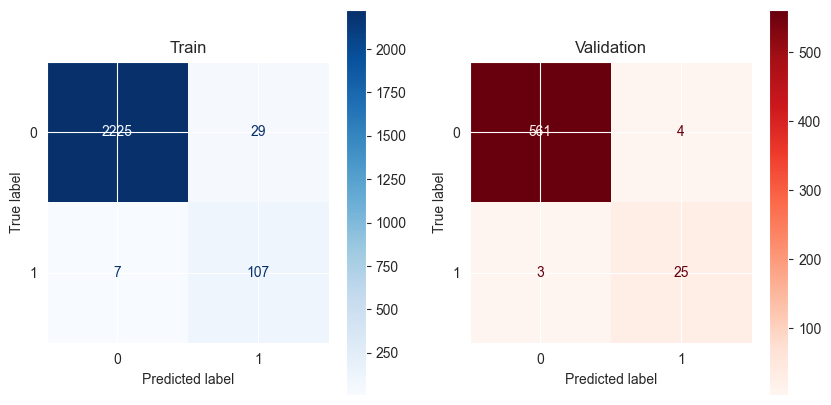

In [4]:
#И снова эти графики, хихи, хохо

fig, axes = plt.subplots(1, 2, figsize = (10, 5))

cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(confusion_matrix = cm_train).plot(ax = axes[0], cmap = "Blues")
axes[0].set_title("Train")

cm_val = confusion_matrix(y_val, y_val_pred)
ConfusionMatrixDisplay(confusion_matrix = cm_val).plot(ax = axes[1], cmap = "Reds")
axes[1].set_title("Validation")
        
plt.show()

In [5]:
best_params = {'C': 10, 'learning_rate': 0.01, 'max_iter': 1000}

precision_array = []
recall_array = []
f1_array = []
roc_auc_array = []
for max_iter in range(0, 1000, 100):
    model = MyLogisticRegression(max_iter = max_iter, learning_rate = best_params['learning_rate'], C = best_params['C'])
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    
    precision = precision_score(y_val, y_pred)
    precision_array.append(precision)
    
    recall = recall_score(y_val, y_pred)
    recall_array.append(recall)
    
    f1 = f1_score(y_val, y_pred)
    f1_array.append(f1)
    
    roc_auc = roc_auc_score(y_val, y_pred)
    roc_auc_array.append(roc_auc)

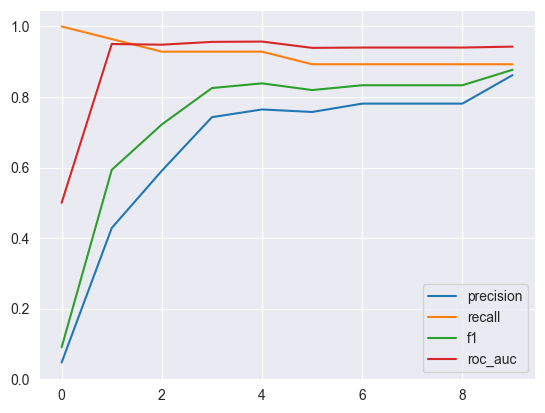

In [6]:
plt.plot(precision_array, label="precision")
plt.plot(recall_array, label="recall")
plt.plot(f1_array, label="f1")
plt.plot(roc_auc_array, label="roc_auc")
plt.legend()
plt.show()

In [7]:
print("C", best_model.C)
print("Веса:", best_model.weights)
print("Смещение", best_model.bias)

C 10
Веса: [ 7.48399046e-03  8.30648121e-03  8.32716204e-03 -4.90833495e-03
  5.08684851e-03 -2.00970488e-03 -3.80198970e-02  1.69389005e-02
  6.81892450e-03 -3.16379127e-04 -2.87086930e-03 -4.29364664e-03
  4.20688199e-04  2.12309497e-02  1.17745009e-02  1.06304774e-02
  3.37849101e-04  8.26311660e-02  7.78052942e-02 -1.03950271e-02
 -3.85791863e-02  2.38651755e-02  5.01786354e-03  5.44659302e-02
  3.91521911e-02 -8.63039877e-03  3.35405603e-02 -5.32242866e-02
  3.11365633e-02  4.64877899e-02  1.47613930e-03  1.62509317e-01
  7.73608580e-02  6.71987028e-02  3.51978079e-01]
Смещение -1.9903580789043338


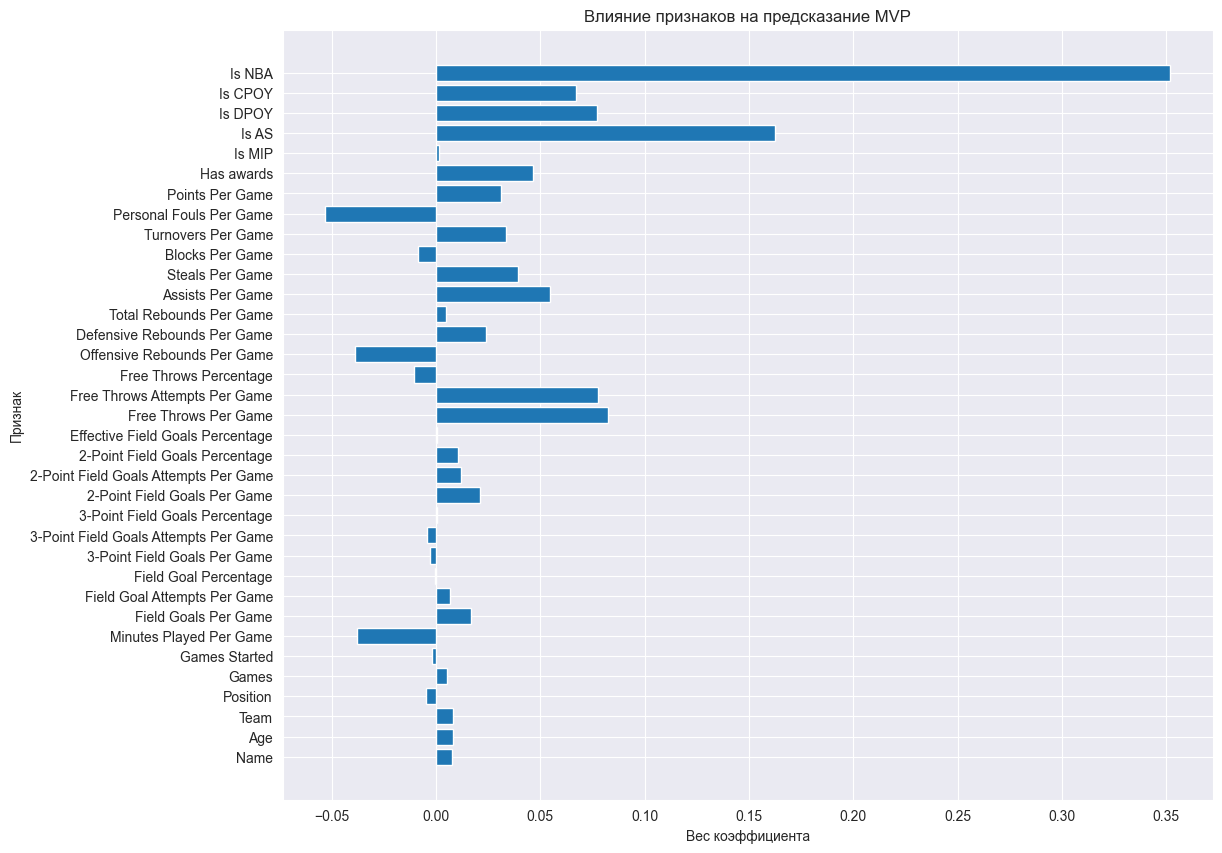

In [8]:
plt.figure(figsize = (12, 10))
features = X.columns
plt.barh(features, best_model.weights)
plt.xlabel("Вес коэффициента")
plt.ylabel("Признак")
plt.title("Влияние признаков на предсказание MVP")
plt.show()

In [9]:
#Вывод: ну как мы видим по графикам обеих моделей, и там и тут у нас есть ["IS NBA"], который сильнее остальных влияет на результаты. Тем ни менее в глаза сразу бросается количество итераций, которое понадобилось - 1000. А сами результаты Precision, Recall, F1-score, ROC-AUC по сути почти такие же. Так что думаю все fine, я молодец, я старалась и я устала читать методички, скролить сайты и делать этот проект, но я довольна. 